## 1. 데이터 준비(MNIST)

    - 손으로 쓴 숫자(0-9)에서 흑백 이미지로 구성된 데이터셋

In [1]:
from pathlib import Path
import requests

    - 경로 설정 담당 python3 라이브러리 `pathlib` 사용
    - request를 이용한 데이터셋 다운로드
    - dataset은 Numpy 포맷으로, 데이터 직렬화를 위해 python 전용 pickle 이용

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = 'mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

    - 각 이미지는 28x28 shape 이고, 784(28x28) 크기를 가진 하나의 행으로 저장되어 있음로,
    이미지를 2d로 재구성함

(50000, 784)


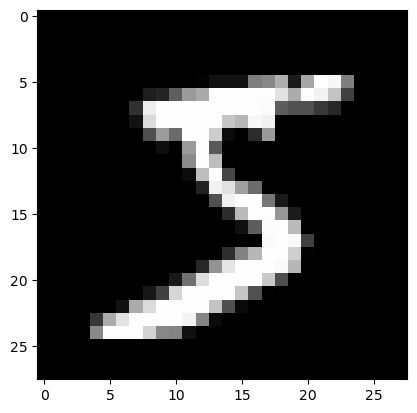

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape)

     - pyTorch는 Numpy 배열보다는 torch.tensor를 사용하므로 데이터 변환

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train,
                                                       x_valid, y_valid))

n,c = x_train.shape

    - x_train, y_train 및 각각의 shape 확인
    - 각 trian 데이터에 대한 min, max 값 확인

In [6]:
print(f" x_train -> {x_train}")
print(f" y_train -> {y_train}")
print(f" x_train shape-> {x_train.shape}, y_train shape -> {y_train.shape}")
print(f" y_train min -> {y_train.min()}, y_train max -> {y_train.max()}")


 x_train -> tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
 y_train -> tensor([5, 0, 4,  ..., 8, 4, 8])
 x_train shape-> torch.Size([50000, 784]), y_train shape -> torch.Size([50000])
 y_train min -> 0, y_train max -> 9


### 2. torch.nn 없이 신경망 만들기

In [7]:
import math

    - 가중치에 대해서 초기화initialzation 한 후 설정함
    ( 해당 단계가 기울기에 포함되는 것을 원하지 않으므로)
    
    - PyTorch는 기울기를 자동으로 계산해주므로, 
    간단한 선형 모델을 만들 수 있음

In [8]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # 가중치 초기화
bias = torch.zeros(10, requires_grad=True)

    - activation function -> softmax 로 구현

In [9]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

    - 배치 (batch) 데이터로 forward learning 

In [10]:
bs = 64
xb= x_train[0:bs]
preds= model(xb)

print(preds[0], preds.shape)

tensor([-2.7802, -2.4729, -1.9740, -2.4568, -2.5062, -1.6982, -2.1844, -2.8260,
        -2.9348, -1.9697], grad_fn=<SelectBackward0>) torch.Size([64, 10])


    -> 예측값 shape는 (64,10)
    - 위의 preds tensor는 gradient function을 담고 있어서,
    backpropagation에 사용함

    - loss_function 을 위한 negative log-likelihood 구현

In [11]:
def null(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func= null

    - 위의 무작위 모델에 대한 loss 확인

In [12]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3700, grad_fn=<NegBackward0>)


    - accuracy matrix 함수
 

In [13]:
def accuracy(output, yb):
    preds= torch.argmax(output, dim=1)
    return (preds==yb).float().mean()

    - 무작위 모델에 대한 accuracy(정확도) 확인

In [14]:
print(accuracy(preds, yb))

tensor(0.0469)


In [15]:
from IPython.core.debugger import set_trace

In [16]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [17]:
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08064761757850647
 학습 후 accuracy -> 1.0


## 3. torch.nn.functional 사용하기

    - 코드 리팩토링(refactoring)

In [18]:
import torch.nn.functional as F

In [19]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [20]:
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08064751327037811
 학습 후 accuracy -> 1.0


## 4. Refactoring

### 4-1.  nn.Module 이용해  refactoring

In [21]:
from torch import nn

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights= nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias= nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb@ self.weights + self.bias
    

In [23]:
model = Mnist_Logistic()

In [24]:
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 2.3490474224090576
 학습 후 accuracy -> 0.0


    - training loop를 위해 parameter 값 업데이트를 
    수동으로 했던 것을 nn.Module을 활용해 간결하게 만듦

In [25]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred= model(xb)
            loss = loss_func(pred,yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit() 
    


In [26]:
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08052727580070496
 학습 후 accuracy -> 1.0


### 4-2.  nn.Linear 이용해  refactoring

In [27]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [28]:
model = Mnist_Logistic()
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 2.354980230331421
 학습 후 accuracy -> 0.0625


In [29]:
fit()

In [30]:
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08151780813932419
 학습 후 accuracy -> 1.0


### 4-3. torch.optim 이용해  refactoring

In [31]:
from torch import optim

In [34]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

for epoch in range(epochs):
    for i in range((n-1)// bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 2.264681339263916
 학습 후 accuracy -> 0.125
 학습 후 loss -> 0.08243892341852188
 학습 후 accuracy -> 1.0


### 4-4. DataSet을 이용해 Refactoring

In [35]:
from torch.utils.data import TensorDataset

In [36]:
train_ds = TensorDataset(x_train, y_train)

In [37]:
model, opt = get_model()
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        pred= model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08139986544847488
 학습 후 accuracy -> 1.0


### 4-5. DataLoader을 이용해 Refactoring

In [38]:
from torch.utils.data import DataLoader

In [41]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [42]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
        
print(f" 학습 후 loss -> {loss_func(model(xb),yb)}")
print(f" 학습 후 accuracy -> {accuracy(model(xb), yb)}")

 학습 후 loss -> 0.08326781541109085
 학습 후 accuracy -> 1.0


## 5.  Validation data 

In [44]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb,yb in valid_dl)
        
    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.3200)
1 tensor(0.2774)


## 6. fit(), get_data() 생성

In [56]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [57]:
import numpy as np

In [58]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
            *[loss_batch(model, loss_func, xb,yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)
        

In [59]:
def get_data(train_ds, valid_ds, bs):
    return (
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

In [60]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3070010386943817
1 0.3012943680882454


## 7. CNN

In [67]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb,4)
        return xb.view(-1, xb.size(1))
    
lr= 0.1

In [68]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3514069197416306
1 0.23066942761540413


## 8. nn.Sequential 사용

In [74]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [76]:
model = nn.Sequential(
        Lambda(preprocess),
        nn.Conv2d(1,16,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16,10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(4),
        Lambda(lambda x: x.view(x.size(0), -1)),
        )

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4239803113460541
1 0.22280159608125685


    - 위의  CNN은 28*28 vector라고 가정하고,
    cnn grid size를 4*4 라고 가정했기 때문에 MNIST에서만 작동함
    
    - 위 가정을 제거해서 모델이 모든 2d channel 이미지에서 작동하게 함

In [77]:
def preprocess(x, y):
    return x.view(-1,1,28,28),y

class WrapperDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))

In [78]:
trian_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

In [79]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [80]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3531580195903778
1 0.2702534495949745


## 9. GPU 사용

In [81]:
print(torch.cuda.is_available())

False


    -> 현재 컴퓨터에 cuda 설치를 안해서 pass
    colab으로 그 이후는 넘어감